## Target: convert a numpy array and or Image directly into a .hdf5 GPR-max model

Parts of this software are directly derived from the gprMax repository
https://github.com/gprMax/gprMax

The GNU license applies, the software is "as is", no warranties for anything, not even implied warranties


In [1]:

import argparse
import os
import h5py
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.signal import find_peaks 

In [4]:
file="drawn/drawn.bmp"
# Filename for geometry (HDF5) file
hdf5file = os.path.splitext(file)[0] + '.h5'
dx=dy=dz=0.002
zcells=1


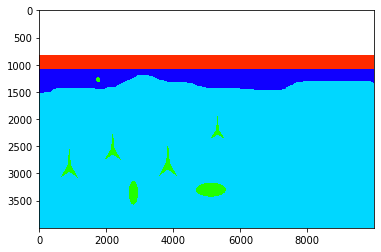

In [5]:
data=cv2.imread(file)
plt.imshow(data,aspect='auto')

Optional read with imread, needs to be .png though
#data=mpimg.imread('tools/drawn/drawn.png')


The resulting array has 3 dimensions since it comes from R,G,B

In [6]:
data.shape

(4000, 10000, 3)

### For our purposes, a greyscale is enough

Taken from: https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
It should look like the matlab version

In [7]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

(4000, 10000)


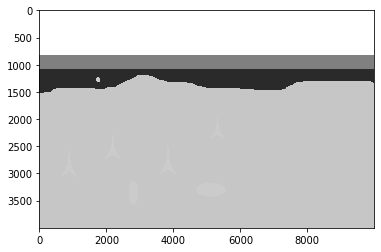

In [8]:
#%matplotlib qt
data_grey=np.floor(rgb2gray(data))
plt.imshow(data_grey,aspect='auto',cmap='gray',vmin=0,vmax=200)
print(data_grey.shape)

Problem: Colour values are not discrete due to image handling. Neither in grey nor in colour

In [9]:
[np.unique(data_grey).shape,np.unique(data).shape]

[(16,), (26,)]

A histogram shows, that we have a few "main" peaks. our count shows, that we also have a few minor ones.

Assuming that the drawn objects have a higher count, we pick the values with a lot of prominence in the historgram of colour values

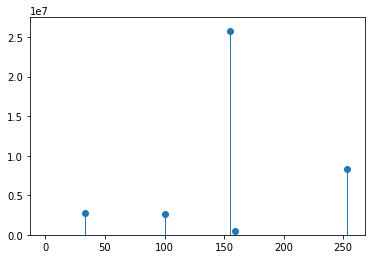

In [10]:
f=plt.figure()
n=plt.hist(data_grey.flatten(),bins=range(255))
peaks,_=find_peaks(np.concatenate(([min(n[0])],n[0],[min(n[0])])), prominence=1000)

f.axes[0].scatter(peaks-1,n[0][peaks-1])
materials=n[1][peaks]

Need to fix our manipulation/concat stuff from detection so we subtract 1, except on the last value. 
Afterwards, the values of the materials should match with the values in the greyscale plot

In [11]:
materials=materials-1
materials[-1]=materials[-1]+1
materials

array([ 33, 100, 155, 159, 254])

In [12]:
# Array to store geometry data (initialised as background, i.e. -1)
arraydata = np.ones((data.shape[0], data.shape[1], zcells), dtype=np.int16) * -1
dx_dy_dz = (dx,dy,dz)

In [13]:
# Write geometry (HDF5) file
with h5py.File(hdf5file, 'w') as fout:

    # Add attribute with name 'dx_dy_dz' for spatial resolution
    fout.attrs['dx_dy_dz'] = dx_dy_dz

    # Use a boolean mask to match selected pixel values with position in image
    for i, material in enumerate(materials):
        mask = data_grey == material
        arraydata[mask] = i
        np.sum(mask)
        print(i,material,np.sum(mask))

    # Write data to file
    fout.create_dataset('data', data=arraydata)

0 33 2793801
1 100 2620000
2 155 25796535
3 159 509526
4 254 8280000


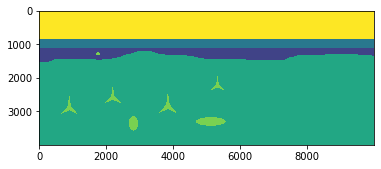

In [14]:
plt.imshow(arraydata[:,:,0])